# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Define transform
- Train Model
- Inference & Save File


In [1]:
# # 필요한 라이브러리를 설치합니다.
# !pip install timm

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [52]:
import os
import time
import random

import pickle
import shutil
import cv2
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [53]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [54]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [55]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        #pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [56]:
# one epoch 학습을 위한 함수입니다.
def val_one_epoch(loader, model, optimizer, loss_fn, device):
    model.eval()
    
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)
        with torch.no_grad():
            preds = model(image)

        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret, train_f1

In [57]:
# csv파일로 분리하기
def train_valid_split(csvpath, savepath, epoch):

    data = pd.read_csv(csvpath)

    x1, x2, _, _ = train_test_split(data,
                                    data['target'],
                                    test_size = 0.2,
                                    shuffle = True,
                                    stratify = data['target'],
                                    random_state = 42)

    x1.to_csv(savepath + '/train/' + str(epoch) + '.csv', index = False)
    x2.to_csv(savepath + '/valid/' + str(epoch) + '.csv', index = False)

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [59]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# data config
data_path = '../data/'

# model config
model_name = 'efficientnet_b0' # 'resnet50' 'efficientnet-b0', ...

# training config
img_size = 224
LR = 1e-3
EPOCHS = 100
BATCH_SIZE = 32
num_workers = 0

# early stop count 
stop_count = 5

cuda


## 4. Define transform
* Albumentation 항목을 정의합니다.

In [326]:
# p 함수가 적용될 확률
trn_transform = A.Compose([
        
    A.Resize(height=img_size, width=img_size),
    
    # 수평,수직 또는 수평 및 수직으로 뒤집는다.
    A.Flip(always_apply=False, p=0.3),
    
    #  -90 ~ 90도 사이로 돌림, 남은 공간은 주변 환경으로 채움 (cv2.BORDER_CONSTAN, cv2.BORDER_REFLECT, cv2.BORDER_REFLECT_101, cv2.BORDER_WRAP)
    A.Rotate(limit=180, p=0.8, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)), 

    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),

    # shift, scale, rotate를 한번에 적용
    A.ShiftScaleRotate(shift_limit=0.4, scale_limit=(0.5, 0.9), rotate_limit=180, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),

    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),

    # 밝기와 대비 변경 (대비를 올리면 어두운색은 더 어둡게, 밝은색은 더 밝게)
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.2, 0.2), p=0.3),
    
    # blur_limit가 클수록 더 흐림
    A.Blur(p=0.2, blur_limit=(3, 8)),
    
    # images normalization
    A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),

    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# val image 변환을 위한 transform 코드
val_transform = A.Compose([
        
    A.Resize(height=img_size, width=img_size),
    
    # 수평,수직 또는 수평 및 수직으로 뒤집는다.
    A.Flip(always_apply=False, p=0.3),
    
    #  -90 ~ 90도 사이로 돌림, 남은 공간은 주변 환경으로 채움 (cv2.BORDER_CONSTAN, cv2.BORDER_REFLECT, cv2.BORDER_REFLECT_101, cv2.BORDER_WRAP)
    A.Rotate(limit=180, p=0.8, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)), 

    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),

    # shift, scale, rotate를 한번에 적용
    A.ShiftScaleRotate(shift_limit=0.4, scale_limit=(0.5, 0.9), rotate_limit=180, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=(255, 255, 255)),

    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),

    # 밝기와 대비 변경 (대비를 올리면 어두운색은 더 어둡게, 밝은색은 더 밝게)
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.2, 0.2), p=0.3),
    
    # blur_limit가 클수록 더 흐림
    A.Blur(p=0.2, blur_limit=(3, 8)),
    
    # images normalization
    A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),

    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [327]:
# load model
model = timm.create_model(
    model_name,
    pretrained=True,
    num_classes=17
).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [328]:
# Dataset 정의
trn_dataset = ImageDataset(
    "../data/EfficientNet-B0_split/train/" + str(epoch) + ".csv",
    "../data/train/",
    transform=trn_transform
)

# DataLoader 정의
trn_loader = DataLoader(
    trn_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [330]:
# 라벨 표시
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
    10: "10",
    11: "11",
    12: "12",
    13: "13",
    14: "14",
    15: "15",
    16: "16",
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

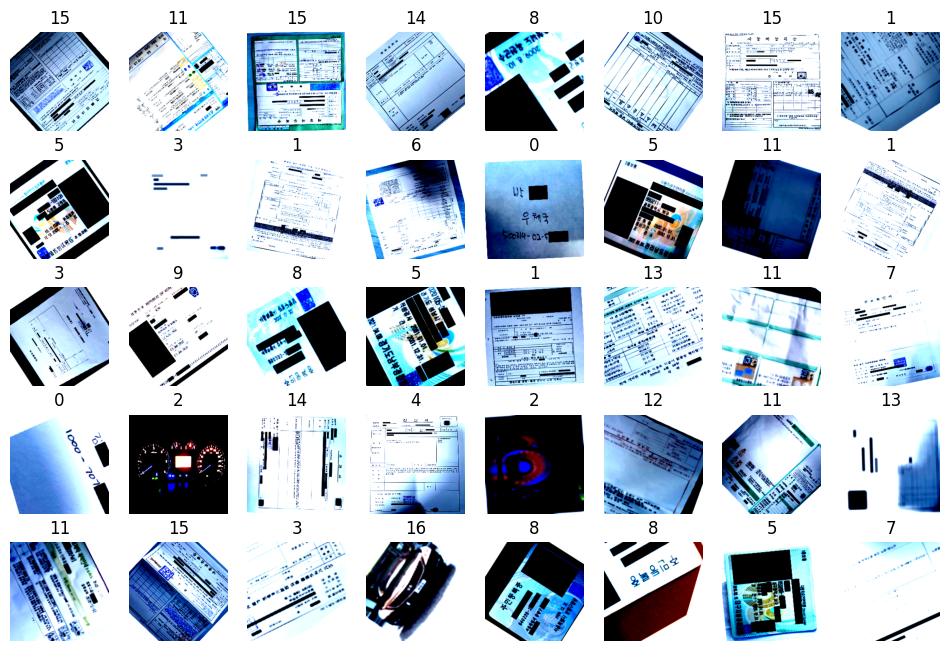

In [331]:
# 이미지 확인 코드 - test와 유사하게 만들어 지는지 확인할 수 있음
figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trn_dataset), size=(1,)).item()
    img, label = trn_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)), cmap='gray')
plt.show()

In [66]:
# ---------- 변수 건들면 안돼
best_epoch = 0
best_f1_score = 0
stop_early_count = 0

for epoch in range(EPOCHS): # EPOCHS
    
   # early stopping 적용
   if stop_early_count == stop_count:
      break
    
   # csv 파일로 분리하기
   train_valid_split('../data/train_label_adj.csv',
                     '../data/EfficientNet-B0_split/',
                     epoch)
    
   # Dataset 정의
   trn_dataset = ImageDataset(
      "../data/EfficientNet-B0_split/train/" + str(epoch) + ".csv",
      "../data/train/",
      transform=trn_transform
   )

   # val _ data만듬
   val_dataset = ImageDataset(
      "../data/EfficientNet-B0_split/valid/" + str(epoch) + ".csv",
      "../data/train/",
      transform = val_transform
   )
   
   # DataLoader 정의
   trn_loader = DataLoader(
      trn_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False
   )

   val_loader = DataLoader(
      val_dataset,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False
   )

   # train 
   ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)

   # valid
   ret2, _train_f1 = val_one_epoch(val_loader, model, optimizer, loss_fn, device=device)
   
   # 보여지는 부분
   print(f"Epoch: {epoch}, Loss: {ret['train_loss']:.4f}, Accuracy: {ret['train_acc']:.4f}, F1-Score: {ret['train_f1']:.4f}")
   print(f"val, val_Accuracy: {ret2['train_acc']:.4f}, val_F1-Score: {ret2['train_f1']:.4f}")
   
   # f1-score을 비교
   if _train_f1 > best_f1_score:
      stop_early_count = 0
      best_epoch = epoch
      best_f1_score = _train_f1
      # 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
      with open('../efficientnet-b0/model_epoch' + str(epoch) + '.pkl', 'wb') as f:
         pickle.dump(model, f)
      
   else:
      stop_early_count += 1

print(f'best epoch: {best_epoch}, best f1 score: {best_f1_score}')

  0%|          | 0/37 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [253]:
# test set
tst_dataset = ImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    transform=tst_transform
)

In [254]:
# test loader
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [ ]:
# 저장된 모델을 불러옵니다.
with open('../efficientnet-b0/model_epoch' + str(best_epoch) + '.pkl', 'rb') as f:
    model = pickle.load(f)
    
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:14<00:00,  6.66it/s]


In [ ]:
model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [ ]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [ ]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [ ]:
pred_df.to_csv("../data/pred.csv", index=False)

In [ ]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,16
2,00396fbc1f6cc21d.jpg,8
3,00471f8038d9c4b6.jpg,8
4,00901f504008d884.jpg,2
